# Applied Data Science Capstone Project -The Battle of Neighborhoods
# New Restaurant Site Evaluation Recommendations
## Michael Hall
## mjhall@ucsd.edu
## December, 2018



## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Gather and prep the data</a>

2. <a href="#item2">Cluster the neighborhoods</a>   
</font>
</div>

## Load Libraries



In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import geopandas as gpd
from shapely.geometry import Point

pd.set_option('display.max_rows', 1000)

print('Libraries imported.')

Libraries imported.


# Gather and prep the Data
#### Get the demographics for the neighborhoods

In [2]:
census2010 = pd.read_csv(r'C:\Users\hall9\OneDrive\Documents\Data Science Certification\Capstone Project\censusacs_2010_sandiego_key.csv')

In [3]:
census2010.dtypes

Neighborhood                   object
Median_Age                    float64
Housing_Owner_Occupied        float64
Not_Housing_Owner_Occupied    float64
Median_Household_Income         int64
Number_of_Households            int64
dtype: object

In [4]:
census2010.sort_values(by=['Neighborhood'],inplace=True)

In [5]:
census2010.describe()

,Median_Age,Housing_Owner_Occupied,Not_Housing_Owner_Occupied,Median_Household_Income,Number_of_Households
count,76.000000,76.000000,76.000000,76.000000,76.000000
mean,37.373684,0.610704,0.389296,76036.197368,18178.105263
std,6.942207,0.229166,0.229166,34379.507173,17141.901903
min,21.900000,0.042638,0.000000,26761.000000,2.000000
25%,32.750000,0.439903,0.203312,51923.500000,4069.250000
50%,37.100000,0.684642,0.315358,66556.500000,13576.500000
75%,41.450000,0.796688,0.560097,85628.500000,31263.500000
max,55.300000,1.000000,0.957362,172692.000000,68118.000000


In [6]:
census2010.isnull().values.any()

False

In [7]:
census2010.head(200)

,Neighborhood,Median_Age,Housing_Owner_Occupied,Not_Housing_Owner_Occupied,Median_Household_Income,Number_of_Households
0,Alpine,42.5,0.706637,0.293363,80168,13647
1,Balboa Park,23.7,1.000000,0.000000,60000,2
2,Barona,37.3,0.763819,0.236181,88720,427
3,Barrio Logan,30.8,0.179196,0.820804,26761,2567
4,Black Mountain Ranch,39.1,0.864151,0.135849,121537,4529
5,Bonsall,44.4,0.849797,0.150203,69541,7764
6,Carmel Mountain Ranch,35.3,0.596236,0.403764,101462,10570
7,Carmel Valley,37.6,0.685895,0.314105,118506,26486
8,Central Mountain,45.8,0.775696,0.224304,57866,4102
10,Clairemont Mesa,39.2,0.616748,0.383252,63998,68118


In [8]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(census2010['Median_Age'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[ 3  3 12 13 15 11 10  2  5  2]
[21.9  25.24 28.58 31.92 35.26 38.6  41.94 45.28 48.62 51.96 55.3 ]


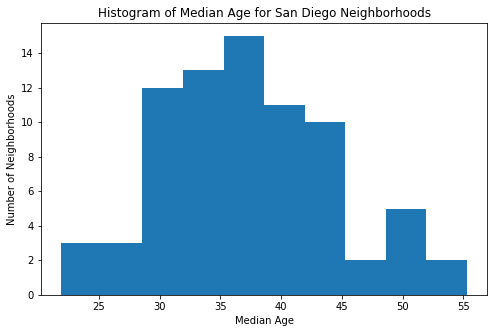

In [9]:
census2010['Median_Age'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Median Age for San Diego Neighborhoods') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Median Age') # add x-label

plt.show()

#### Let's break the neighborhoods into three age groups: young < 35, middle 35-45, older > 45

In [10]:
census2010['Age_Young'] = np.where(census2010['Median_Age']<= 35, 1, 0)
census2010['Age_Old'] = np.where(census2010['Median_Age']>= 45, 1, 0)
census2010['Age_Middle'] = np.where((census2010['Median_Age']> 35) & (census2010['Median_Age']<= 45), 1, 0)

[ 2  2  9  6  5  9 12 15 15  1]
[0.0426375  0.13837375 0.23411    0.32984625 0.4255825  0.52131875
 0.617055   0.71279125 0.8085275  0.90426375 1.        ]


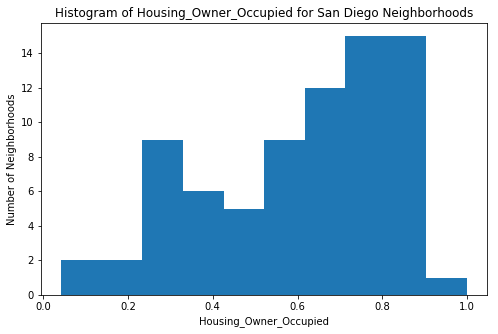

In [11]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(census2010['Housing_Owner_Occupied'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
census2010['Housing_Owner_Occupied'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Housing_Owner_Occupied for San Diego Neighborhoods') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Housing_Owner_Occupied') # add x-label

plt.show()

In [12]:
census2010['Rent'] = np.where(census2010['Housing_Owner_Occupied']<= 0.3, 1,0)
census2010['Rent_or_Own'] = np.where((census2010['Housing_Owner_Occupied']> 0.3) & (census2010['Housing_Owner_Occupied']<0.6 ), 1, 0)
census2010['Own'] = np.where(census2010['Housing_Owner_Occupied']>= 0.6, 1, 0)

[ 7 19 15 16  1  5  6  3  1  3]
[ 26761.   41354.1  55947.2  70540.3  85133.4  99726.5 114319.6 128912.7
 143505.8 158098.9 172692. ]


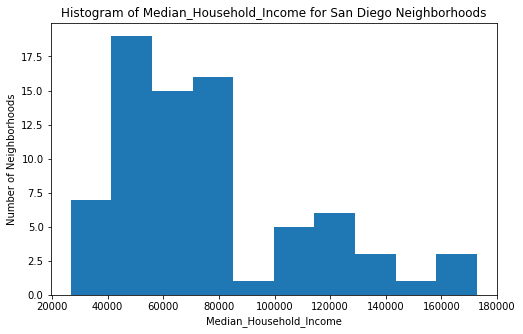

In [13]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(census2010['Median_Household_Income'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
census2010['Median_Household_Income'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Median_Household_Income for San Diego Neighborhoods') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Median_Household_Income') # add x-label

plt.show()

In [14]:
census2010['Low_Income'] = np.where(census2010['Median_Household_Income']<= 60000, 1, 0)
census2010['Middle_Income'] = np.where((census2010['Median_Household_Income']> 60000) & (census2010['Median_Household_Income']<120000), 1,0)
census2010['High_Income'] = np.where(census2010['Median_Household_Income']>= 120000, 1,0)

[29  9  9  6  8  4  5  4  1  1]
[2.00000e+00 6.81360e+03 1.36252e+04 2.04368e+04 2.72484e+04 3.40600e+04
 4.08716e+04 4.76832e+04 5.44948e+04 6.13064e+04 6.81180e+04]


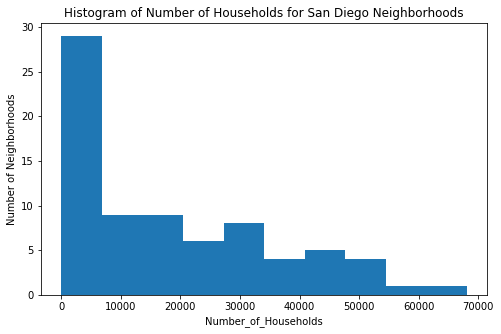

In [15]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(census2010['Number_of_Households'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins
census2010['Number_of_Households'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Number of Households for San Diego Neighborhoods') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Number_of_Households') # add x-label

plt.show()

In [16]:
census2010['Small_Number_Households'] = np.where(census2010['Number_of_Households']<= 5000, 1,0)
census2010['Middle_Number_Households'] = np.where((census2010['Number_of_Households']> 5000) & (census2010['Number_of_Households']<40000), 1,0)
census2010['High_Number_Households'] = np.where(census2010['Number_of_Households']>= 40000, 1,0)

In [17]:
census2010.head(100)

,Neighborhood,Median_Age,Housing_Owner_Occupied,Not_Housing_Owner_Occupied,Median_Household_Income,Number_of_Households,Age_Young,Age_Old,Age_Middle,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households
0,Alpine,42.5,0.706637,0.293363,80168,13647,0,0,1,0,0,1,0,1,0,0,1,0
1,Balboa Park,23.7,1.000000,0.000000,60000,2,1,0,0,0,0,1,1,0,0,1,0,0
2,Barona,37.3,0.763819,0.236181,88720,427,0,0,1,0,0,1,0,1,0,1,0,0
3,Barrio Logan,30.8,0.179196,0.820804,26761,2567,1,0,0,1,0,0,1,0,0,1,0,0
4,Black Mountain Ranch,39.1,0.864151,0.135849,121537,4529,0,0,1,0,0,1,0,0,1,1,0,0
5,Bonsall,44.4,0.849797,0.150203,69541,7764,0,0,1,0,0,1,0,1,0,0,1,0
6,Carmel Mountain Ranch,35.3,0.596236,0.403764,101462,10570,0,0,1,0,1,0,0,1,0,0,1,0
7,Carmel Valley,37.6,0.685895,0.314105,118506,26486,0,0,1,0,0,1,0,1,0,0,1,0
8,Central Mountain,45.8,0.775696,0.224304,57866,4102,0,1,0,0,0,1,1,0,0,1,0,0
10,Clairemont Mesa,39.2,0.616748,0.383252,63998,68118,0,0,1,0,0,1,0,1,0,0,0,1


In [18]:
census2010=census2010.drop(['Median_Age', 'Housing_Owner_Occupied', 'Not_Housing_Owner_Occupied', 'Median_Household_Income', 'Number_of_Households'], axis=1, inplace=False)

In [19]:
census2010.head()

,Neighborhood,Age_Young,Age_Old,Age_Middle,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households
0,Alpine,0,0,1,0,0,1,0,1,0,0,1,0
1,Balboa Park,1,0,0,0,0,1,1,0,0,1,0,0
2,Barona,0,0,1,0,0,1,0,1,0,1,0,0
3,Barrio Logan,1,0,0,1,0,0,1,0,0,1,0,0
4,Black Mountain Ranch,0,0,1,0,0,1,0,0,1,1,0,0


#### Get the unincorporated and city neighborhoods in geojson format

In [20]:
url1 = "https://opendata.arcgis.com/datasets/687b4e8f9cc9466cb81e733831992e50_1.geojson"
url0 = "https://opendata.arcgis.com/datasets/687b4e8f9cc9466cb81e733831992e50_0.geojson"
data1 = gpd.read_file(url1)
data0 = gpd.read_file(url0)

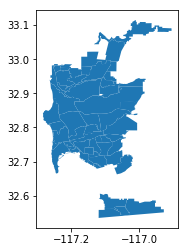

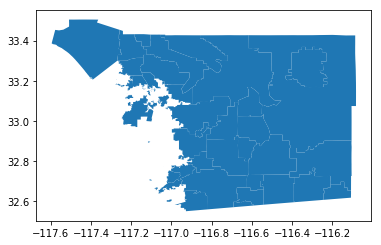

In [21]:
data0.plot()
data1.plot()

In [22]:
data0.head(200)

,OBJECTID,CPCODE,CPNAME,ACREAGE,Shape_STAr,Shape_STLe,ShapeSTArea,ShapeSTLength,geometry
0,1,37,"SOUTHEASTERN SAN DIEGO,SOUTHEASTERN",3049.665754,1.328429e+08,51202.267742,1.328429e+08,51202.267742,POLYGON ((-117.1029111739245 32.71814235525035...
1,2,97,MILITARY FACILITIES,444.218254,1.935007e+07,31304.013099,1.935007e+07,31304.013099,POLYGON ((-117.1261781440585 32.69283296436731...
2,3,25,OTAY MESA-NESTOR,5367.842306,2.338223e+08,95210.708583,2.338223e+08,95210.708583,POLYGON ((-117.1142588786256 32.60543844621487...
3,4,26,OTAY MESA,9316.183135,4.058113e+08,105906.774574,4.058113e+08,105906.774574,POLYGON ((-117.0203341323668 32.59112852862513...
4,5,33,SAN YSIDRO,1862.297555,8.112136e+07,44119.185660,8.112136e+07,44119.185660,POLYGON ((-117.0592782437243 32.56810509330174...
5,6,39,TIJUANA RIVER VALLEY,3589.197667,1.563448e+08,64780.524341,1.563448e+08,64780.524341,"POLYGON ((-117.081725543259 32.56115850130549,..."
6,7,19,MISSION VALLEY,3215.865379,1.400721e+08,89550.193886,1.400721e+08,89550.193886,POLYGON ((-117.1683344247963 32.75898912312842...
7,8,24,OLD TOWN SAN DIEGO,274.789353,1.196978e+07,17987.280281,1.196978e+07,17987.280281,POLYGON ((-117.1901020517723 32.75835888110149...
8,9,14,MIDWAY-PACIFIC HIGHWAY,905.319245,3.943555e+07,48034.808481,3.943555e+07,48034.808481,POLYGON ((-117.1745251929204 32.73512776847029...
9,10,56,MID-CITY:CITY HEIGHTS,2935.523506,1.278709e+08,53479.764339,1.278709e+08,53479.764339,"POLYGON ((-117.117979179272 32.71711079750057,..."


In [23]:
data1.head(200)

,OBJECTID,AREA_,PERIMETER,CPASG_LABE,CPANAME,SPONSORNAM,CPASG,SUBREGPLAN,ShapeSTArea,ShapeSTLength,geometry
0,1,3.259688e+09,3.396916e+05,Borrego Springs,Desert,BORREGO SPRINGS,190401,Desert Subregional Plan Area,3.259688e+09,3.396916e+05,POLYGON ((-116.4088086601976 33.22687769654227...
1,2,1.454254e+09,1.800429e+05,Julian,Julian,,192200,,1.454254e+09,1.800429e+05,POLYGON ((-116.5465563617742 33.07967353812863...
2,3,1.961028e+09,2.468173e+05,Central Mountain,Central Mountain,,190200,Central Mountain Subregional Plan Area,1.961028e+09,2.468178e+05,POLYGON ((-116.6678364877542 33.09441969400916...
3,4,1.945744e+09,1.981851e+05,Cuyamaca,Central Mountain,CUYAMACA,190201,Central Mountain Subregional Plan Area,1.945744e+09,1.981817e+05,POLYGON ((-116.5411744767211 33.02794634825228...
4,5,2.288579e+08,1.020612e+05,Barona,Barona,,199800,,2.288578e+08,1.020557e+05,POLYGON ((-116.8235568251763 32.96416738744541...
5,6,1.852071e+06,5.444031e+03,Barona,Barona,,199800,,1.852071e+06,5.444031e+03,POLYGON ((-116.8194374144634 32.96417302266025...
6,7,4.037337e+09,3.009832e+05,Pine Valley,Central Mountain,PINE VALLEY,190203,Central Mountain Subregional Plan Area,4.037337e+09,3.009810e+05,POLYGON ((-116.4081731085322 32.86569645957154...
7,8,9.120529e+08,1.616524e+05,Descanso,Central Mountain,DESCANSO,190202,Central Mountain Subregional Plan Area,9.120536e+08,1.616475e+05,"POLYGON ((-116.669222617182 32.927301465383, -..."
8,9,2.968006e+09,2.602145e+05,Alpine,Alpine,,190100,,2.968006e+09,2.602145e+05,POLYGON ((-116.6863799731254 32.90574647471001...
9,10,5.554946e+09,4.812415e+05,Mountain Empire,Mountain Empire,,190800,Mountain Empire Subregional Plan Area,5.554946e+09,4.812415e+05,POLYGON ((-116.1058182270597 32.65367074323294...


#### get the centroids of all of the polygon areas for both datasets

In [24]:
data0['xy']=data0.centroid
data0['Longitude'] = data0.geometry.centroid.x
data0['Latitude'] = data0.geometry.centroid.y
data1['xy']=data1.centroid
data1['Longitude'] = data1.geometry.centroid.x
data1['Latitude'] = data1.geometry.centroid.y

In [25]:
data0.head(200)

,OBJECTID,CPCODE,CPNAME,ACREAGE,Shape_STAr,Shape_STLe,ShapeSTArea,ShapeSTLength,geometry,xy,Longitude,Latitude
0,1,37,"SOUTHEASTERN SAN DIEGO,SOUTHEASTERN",3049.665754,1.328429e+08,51202.267742,1.328429e+08,51202.267742,POLYGON ((-117.1029111739245 32.71814235525035...,POINT (-117.1174903878708 32.7026673339293),-117.117490,32.702667
1,2,97,MILITARY FACILITIES,444.218254,1.935007e+07,31304.013099,1.935007e+07,31304.013099,POLYGON ((-117.1261781440585 32.69283296436731...,POINT (-117.1240912193632 32.68601617391298),-117.124091,32.686016
2,3,25,OTAY MESA-NESTOR,5367.842306,2.338223e+08,95210.708583,2.338223e+08,95210.708583,POLYGON ((-117.1142588786256 32.60543844621487...,POINT (-117.0781243496628 32.58086861499208),-117.078124,32.580869
3,4,26,OTAY MESA,9316.183135,4.058113e+08,105906.774574,4.058113e+08,105906.774574,POLYGON ((-117.0203341323668 32.59112852862513...,POINT (-116.9910652049896 32.5650854614376),-116.991065,32.565085
4,5,33,SAN YSIDRO,1862.297555,8.112136e+07,44119.185660,8.112136e+07,44119.185660,POLYGON ((-117.0592782437243 32.56810509330174...,POINT (-117.0477197599311 32.55572147678751),-117.047720,32.555721
5,6,39,TIJUANA RIVER VALLEY,3589.197667,1.563448e+08,64780.524341,1.563448e+08,64780.524341,"POLYGON ((-117.081725543259 32.56115850130549,...",POINT (-117.0881653313862 32.54809309990557),-117.088165,32.548093
6,7,19,MISSION VALLEY,3215.865379,1.400721e+08,89550.193886,1.400721e+08,89550.193886,POLYGON ((-117.1683344247963 32.75898912312842...,POINT (-117.1458222530955 32.77334860306429),-117.145822,32.773349
7,8,24,OLD TOWN SAN DIEGO,274.789353,1.196978e+07,17987.280281,1.196978e+07,17987.280281,POLYGON ((-117.1901020517723 32.75835888110149...,POINT (-117.1959809661436 32.7552189392102),-117.195981,32.755219
8,9,14,MIDWAY-PACIFIC HIGHWAY,905.319245,3.943555e+07,48034.808481,3.943555e+07,48034.808481,POLYGON ((-117.1745251929204 32.73512776847029...,POINT (-117.2027113706871 32.74916311230599),-117.202711,32.749163
9,10,56,MID-CITY:CITY HEIGHTS,2935.523506,1.278709e+08,53479.764339,1.278709e+08,53479.764339,"POLYGON ((-117.117979179272 32.71711079750057,...",POINT (-117.1012842212063 32.740168553798),-117.101284,32.740169


In [26]:
data1.head(100)

,OBJECTID,AREA_,PERIMETER,CPASG_LABE,CPANAME,SPONSORNAM,CPASG,SUBREGPLAN,ShapeSTArea,ShapeSTLength,geometry,xy,Longitude,Latitude
0,1,3.259688e+09,3.396916e+05,Borrego Springs,Desert,BORREGO SPRINGS,190401,Desert Subregional Plan Area,3.259688e+09,3.396916e+05,POLYGON ((-116.4088086601976 33.22687769654227...,POINT (-116.31828855608 33.26537214212854),-116.318289,33.265372
1,2,1.454254e+09,1.800429e+05,Julian,Julian,,192200,,1.454254e+09,1.800429e+05,POLYGON ((-116.5465563617742 33.07967353812863...,POINT (-116.6072357711466 33.0787883560051),-116.607236,33.078788
2,3,1.961028e+09,2.468173e+05,Central Mountain,Central Mountain,,190200,Central Mountain Subregional Plan Area,1.961028e+09,2.468178e+05,POLYGON ((-116.6678364877542 33.09441969400916...,POINT (-116.7280217534762 32.97647718085298),-116.728022,32.976477
3,4,1.945744e+09,1.981851e+05,Cuyamaca,Central Mountain,CUYAMACA,190201,Central Mountain Subregional Plan Area,1.945744e+09,1.981817e+05,POLYGON ((-116.5411744767211 33.02794634825228...,POINT (-116.5905797635732 32.9596772598013),-116.590580,32.959677
4,5,2.288579e+08,1.020612e+05,Barona,Barona,,199800,,2.288578e+08,1.020557e+05,POLYGON ((-116.8235568251763 32.96416738744541...,POINT (-116.8480234415344 32.95424716262756),-116.848023,32.954247
5,6,1.852071e+06,5.444031e+03,Barona,Barona,,199800,,1.852071e+06,5.444031e+03,POLYGON ((-116.8194374144634 32.96417302266025...,POINT (-116.8172226358552 32.96606226428811),-116.817223,32.966062
6,7,4.037337e+09,3.009832e+05,Pine Valley,Central Mountain,PINE VALLEY,190203,Central Mountain Subregional Plan Area,4.037337e+09,3.009810e+05,POLYGON ((-116.4081731085322 32.86569645957154...,POINT (-116.4991502215778 32.81588224806875),-116.499150,32.815882
7,8,9.120529e+08,1.616524e+05,Descanso,Central Mountain,DESCANSO,190202,Central Mountain Subregional Plan Area,9.120536e+08,1.616475e+05,"POLYGON ((-116.669222617182 32.927301465383, -...",POINT (-116.6321268697172 32.8673321663176),-116.632127,32.867332
8,9,2.968006e+09,2.602145e+05,Alpine,Alpine,,190100,,2.968006e+09,2.602145e+05,POLYGON ((-116.6863799731254 32.90574647471001...,POINT (-116.7226544080186 32.82140031311656),-116.722654,32.821400
9,10,5.554946e+09,4.812415e+05,Mountain Empire,Mountain Empire,,190800,Mountain Empire Subregional Plan Area,5.554946e+09,4.812415e+05,POLYGON ((-116.1058182270597 32.65367074323294...,POINT (-116.2295045554394 32.79689028127009),-116.229505,32.796890


In [27]:
print('shape of data 0:', data0.shape,'\t shape of data1: ',data1.shape )

shape of data 0: (63, 12) 	 shape of data1:  (80, 14)


#### Copy just the required columns from the geojson data to dataframes

In [28]:
df0 = pd.DataFrame(data0)
df0_out = df0.drop(['OBJECTID','CPCODE','ACREAGE', 'Shape_STAr', 'Shape_STLe','ShapeSTArea', 'ShapeSTLength', 'geometry', 'xy'],axis=1)
df1 = pd.DataFrame(data1)
df1_out = df1.drop(['OBJECTID', 'AREA_', 'PERIMETER','CPANAME' , 'SPONSORNAM',
       'CPASG', 'SUBREGPLAN', 'ShapeSTArea', 'ShapeSTLength', 'geometry', 'xy'],axis=1)
df1_out.rename(columns={'CPASG_LABE': 'CPNAME'}, inplace=True)
print('shape of data 0:', df0_out.shape,'\t shape of data1: ',df1_out.shape )

shape of data 0: (63, 3) 	 shape of data1:  (80, 3)


#### Merge the two datasets

In [29]:
sd_out = pd.concat([df0_out,df1_out], ignore_index=True, sort=False)
sd_out.sort_values(by=['CPNAME'],inplace=True)
sd_out.head(200)

,CPNAME,Longitude,Latitude
71,Alpine,-116.722654,32.821400
30,BALBOA PARK,-117.145973,32.731130
19,BARRIO LOGAN,-117.137449,32.694519
42,BLACK MOUNTAIN RANCH,-117.140487,32.998328
67,Barona,-116.848023,32.954247
68,Barona,-116.817223,32.966062
84,Bonsall,-117.196217,33.269831
63,Borrego Springs,-116.318289,33.265372
79,Boulevard,-116.308556,32.669845
43,CARMEL MOUNTAIN RANCH,-117.077327,32.977431


#### Drop the duplicate polygons for the non-continguous rural neighborhoods

In [30]:
sd_out.drop_duplicates('CPNAME',keep='first',inplace=True)
sd_out.head()

,CPNAME,Longitude,Latitude
71,Alpine,-116.722654,32.821400
30,BALBOA PARK,-117.145973,32.731130
19,BARRIO LOGAN,-117.137449,32.694519
42,BLACK MOUNTAIN RANCH,-117.140487,32.998328
67,Barona,-116.848023,32.954247


In [31]:
sd_out['CPNAME'] = sd_out['CPNAME'].str.title()
sd_out.reset_index(drop=True, inplace=True)
sd_out.rename(columns={'CPNAME': 'Neighborhood'}, inplace=True)
sd_out.head(200)

,Neighborhood,Longitude,Latitude
0,Alpine,-116.722654,32.821400
1,Balboa Park,-117.145973,32.731130
2,Barrio Logan,-117.137449,32.694519
3,Black Mountain Ranch,-117.140487,32.998328
4,Barona,-116.848023,32.954247
5,Bonsall,-117.196217,33.269831
6,Borrego Springs,-116.318289,33.265372
7,Boulevard,-116.308556,32.669845
8,Carmel Mountain Ranch,-117.077327,32.977431
9,Carmel Valley,-117.220355,32.944332


#### Let's plot the neighborhoods and the current restaurant location on a map

In [32]:
address = 'Solana Beach, CA'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Solana Beach are {}, {}.'.format(latitude, longitude))

C:\Users\hall9\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Solana Beach are 32.9905597, -117.2691316.


In [33]:
# create map of New York using latitude and longitude values
map_sandiego = folium.Map(location=[latitude, longitude], zoom_start=10)

folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup='Solana Beach',
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
        ).add_to(map_sandiego)
      
# add markers to map
for lat, lng,  neighborhood in zip(sd_out['Latitude'], sd_out['Longitude'], sd_out['Neighborhood']):
    label = format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
        ).add_to(map_sandiego)  
    
map_sandiego

### Get the venue data for all of the neighborhoods

#### Foursquare credentials

In [34]:
CLIENT_ID = 'BMD4FONSKYSIPKHCD30RAHEB300UJZJ3COXKHTIP2SK4QRVY' # your Foursquare ID
CLIENT_SECRET = 'B4AA4OOAJJWVLI5UUO52QBKD4XA0ZKDEGM2MR3V5AW400SPR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BMD4FONSKYSIPKHCD30RAHEB300UJZJ3COXKHTIP2SK4QRVY
CLIENT_SECRET:B4AA4OOAJJWVLI5UUO52QBKD4XA0ZKDEGM2MR3V5AW400SPR


In [35]:
sd_out.loc[0, 'Neighborhood']

'Alpine'

In [36]:
neighborhood_latitude = sd_out.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = sd_out.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = sd_out.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Alpine are 32.821400313116555, -116.72265440801856.


#### Now, let's get the top 100 venues that are in Alpine within a radius of 2500 meters

In [37]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 2500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=BMD4FONSKYSIPKHCD30RAHEB300UJZJ3COXKHTIP2SK4QRVY&client_secret=B4AA4OOAJJWVLI5UUO52QBKD4XA0ZKDEGM2MR3V5AW400SPR&v=20180605&ll=32.821400313116555,-116.72265440801856&radius=2500&limit=100'

In [38]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c1522e24c1f6701650332df'},
 'response': {'headerLocation': 'Alpine',
  'headerFullLocation': 'Alpine',
  'headerLocationGranularity': 'city',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 32.84390033561658,
    'lng': -116.69593026624901},
   'sw': {'lat': 32.79890029061653, 'lng': -116.7493785497881}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4dfbc526d22df89d59215430',
       'name': 'Eddie Bauer Outlet',
       'location': {'address': 'Willows Rd',
        'lat': 32.84005800811842,
        'lng': -116.70811969823917,
        'labeledLatLngs': [{'label': 'display',
          'lat': 32.84005800811842,
          'lng': -116.70811969823917}],
        'distance': 2482,
        'postalCode': '92101',
        'cc': 'US',

In [39]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [40]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(100)

,name,categories,lat,lng
0,Eddie Bauer Outlet,Clothing Store,32.840058,-116.708120
1,Palo Verdes Lake,Lake,32.813536,-116.729736
2,Frosty Acres,Farmers Market,32.833732,-116.728768
3,Alpine Mountain Liquor,Liquor Store,32.835015,-116.727490
4,Viejas Outlet Center,Shopping Mall,32.834877,-116.728065
5,"Henderson Sculptural Arts, Inc.",Home Service,32.832271,-116.701477
6,Native Dreams Day Spa,Spa,32.840046,-116.707975


In [41]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

7 venues were returned by Foursquare.


In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
sandiego_venues = getNearbyVenues(names=sd_out['Neighborhood'],
                                   latitudes=sd_out['Latitude'],
                                   longitudes=sd_out['Longitude']
                                  )

Alpine
Balboa Park
Barrio Logan
Black Mountain Ranch
Barona
Bonsall
Borrego Springs
Boulevard
Carmel Mountain Ranch
Carmel Valley
Clairemont Mesa
College Area
Central Mountain
County Islands
Crest - Dehesa
Cuyamaca
Del Mar Mesa
Downtown
Descanso
Desert
East Elliott
Encanto Neighborhoods,Southeastern
Fairbanks Ranch Country Club
Fallbrook
Greater Golden Hill
Greater North Park
Hidden Meadows
Jacumba
Jamul
Julian
Kearny Mesa
La Jolla
Linda Vista
Los Penasquitos Canyon
Lake Morena / Campo
Lakeside
Mid-City:City Heights
Mid-City:Eastern Area
Mid-City:Kensington-Talmadge
Mid-City:Normal Heights
Midway-Pacific Highway
Military Facilities
Mira Mesa
Miramar Ranch North
Mission Bay Park
Mission Beach
Mission Valley
Mountain Empire
Navajo
Ncfua Subarea Ii
North County Metro
North Mountain
Ocean Beach
Old Town San Diego
Otay Mesa
Otay Mesa-Nestor
Otay
Pacific Beach
Pacific Highlands Ranch
Peninsula
Pala - Pauma
Palomar Mountain
Pendleton - De Luz
Pine Valley
Potrero
Rancho Bernardo
Rancho Encanta

#### let's check the sizes of the venues dataframe

In [44]:
print(sandiego_venues.shape)
sandiego_venues.head()

(6780, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alpine,32.8214,-116.722654,Nike Factory Store,32.840301,-116.704907,Sporting Goods Shop
1,Alpine,32.8214,-116.722654,Viejas Outlet Center,32.840484,-116.705203,Shopping Mall
2,Alpine,32.8214,-116.722654,Viejas Casino & Resort,32.842314,-116.705082,Casino
3,Alpine,32.8214,-116.722654,V Lounge -Viejas Casino,32.842101,-116.706052,Lounge
4,Alpine,32.8214,-116.722654,Adriano's Pizza Grotto,32.840887,-116.704994,Pizza Place


In [45]:
sandiego_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alpine,56,56,56,56,56,56
Balboa Park,100,100,100,100,100,100
Barona,21,21,21,21,21,21
Barrio Logan,100,100,100,100,100,100
Black Mountain Ranch,100,100,100,100,100,100
Bonsall,33,33,33,33,33,33
Borrego Springs,8,8,8,8,8,8
Boulevard,7,7,7,7,7,7
Carmel Mountain Ranch,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [46]:
print('There are {} uniques categories.'.format(len(sandiego_venues['Venue Category'].unique())))

There are 331 uniques categories.


#### Analyze the neighborhoods

In [47]:
# one hot encoding
sandiego_onehot = pd.get_dummies(sandiego_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sandiego_onehot['Neighborhood'] = sandiego_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sandiego_onehot.columns[-1]] + list(sandiego_onehot.columns[:-1])
sandiego_onehot = sandiego_onehot[fixed_columns]

sandiego_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Cafeteria,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Donut Shop,Drive-in Theater,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Exhibit,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Military Base,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,RV Park,Racecourse,Racetrack,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Lodge,Skydiving Drop Zone,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,State / Prov

In [48]:
sandiego_onehot.shape

(6780, 331)

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [49]:
sandiego_grouped = sandiego_onehot.groupby('Neighborhood').mean().reset_index()
sandiego_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Cafeteria,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Donut Shop,Drive-in Theater,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Exhibit,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Military Base,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,RV Park,Racecourse,Racetrack,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Lodge,Skydiving Drop Zone,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,State / Prov

#### Let's confirm the new size

In [50]:
sandiego_grouped.shape

(93, 331)

#### Let's print each neighborhood along with the top 5 most common venues

In [51]:
num_top_venues = 5

for hood in sandiego_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sandiego_grouped[sandiego_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alpine----
                 venue  freq
0       Clothing Store  0.09
1           Shoe Store  0.07
2   Mexican Restaurant  0.05
3  American Restaurant  0.04
4       Sandwich Place  0.04


----Balboa Park----
                 venue  freq
0          Zoo Exhibit  0.11
1   Italian Restaurant  0.05
2  American Restaurant  0.05
3          Pizza Place  0.04
4              Brewery  0.03


----Barona----
                  venue  freq
0                Casino  0.14
1   American Restaurant  0.14
2                Buffet  0.05
3         Hot Dog Joint  0.05
4  Gym / Fitness Center  0.05


----Barrio Logan----
                venue  freq
0               Hotel  0.12
1                Park  0.06
2                 Bar  0.06
3             Brewery  0.05
4  Mexican Restaurant  0.05


----Black Mountain Ranch----
                venue  freq
0         Coffee Shop  0.08
1      Sandwich Place  0.05
2  Mexican Restaurant  0.05
3                 Gym  0.04
4    Sushi Restaurant  0.04


----Bonsall----
          

4          Coffee Shop  0.03


----Mission Valley----
                 venue  freq
0  American Restaurant  0.08
1        Grocery Store  0.05
2          Pizza Place  0.04
3   Mexican Restaurant  0.04
4          Coffee Shop  0.04


----Mountain Empire----
            venue  freq
0           Trail  0.25
1      Campground  0.25
2      Playground  0.25
3  Scenic Lookout  0.25
4     Zoo Exhibit  0.00


----Navajo----
                venue  freq
0               Trail  0.05
1         Coffee Shop  0.05
2       Grocery Store  0.05
3                Park  0.04
4  Mexican Restaurant  0.04


----Ncfua Subarea Ii----
                 venue  freq
0          Coffee Shop  0.10
1   Seafood Restaurant  0.06
2  American Restaurant  0.06
3          Pizza Place  0.05
4                Beach  0.05


----North County Metro----
                venue  freq
0  Mexican Restaurant  0.05
1      Cosmetics Shop  0.04
2                Park  0.04
3        Burger Joint  0.04
4      Clothing Store  0.04


----North Mountai

#### Let's put that into a *pandas* dataframe

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sandiego_grouped['Neighborhood']

for ind in np.arange(sandiego_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sandiego_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alpine,Clothing Store,Shoe Store,Mexican Restaurant,Grocery Store,Sandwich Place,Accessories Store,Fast Food Restaurant,Kids Store,American Restaurant,Casino
1,Balboa Park,Zoo Exhibit,American Restaurant,Italian Restaurant,Pizza Place,Theater,Brewery,Farmers Market,Mexican Restaurant,Park,Zoo
2,Barona,Casino,American Restaurant,Café,Mexican Restaurant,Gym / Fitness Center,Athletics & Sports,Asian Restaurant,Steakhouse,Park,Italian Restaurant
3,Barrio Logan,Hotel,Park,Bar,Brewery,Mexican Restaurant,Breakfast Spot,Café,Steakhouse,Taco Place,Italian Restaurant
4,Black Mountain Ranch,Coffee Shop,Mexican Restaurant,Sandwich Place,Gym,Sushi Restaurant,Gym / Fitness Center,Golf Course,Grocery Store,Pizza Place,Video Store
5,Bonsall,Golf Course,Farm,Mexican Restaurant,Garden Center,Fast Food Restaurant,Food & Drink Shop,Garden,Bed & Breakfast,Scenic Lookout,Liquor Store
6,Borrego Springs,Scenic Lookout,Golf Course,Hotel,Home Service,Campground,New American Restaurant,Farm,Fast Food Restaurant,Eye Doctor,Fabric Shop
7,Boulevard,Restaurant,Food,RV Park,Mountain,Scenic Lookout,Resort,Zoo,Eye Doctor,Fabric Shop,Fair
8,Carmel Mountain Ranch,Coffee Shop,Mexican Restaurant,Grocery Store,Sushi Restaurant,Chinese Restaurant,Italian Restaurant,Pizza Place,Sandwich Place,Donut Shop,Greek Restaurant
9,Carmel Valley,Coffee Shop,Seafood Restaurant,American Restaurant,Trail,Mexican Restaurant,Beach,Park,Restaurant,Golf Course,Italian Restaurant


## 4. Cluster Neighborhoods

#### Lets merge the venue and demographic attributes for the neighborhoods

In [54]:
sandiego_demos = pd.merge(sandiego_grouped, census2010, on='Neighborhood', how='inner')

In [55]:
sandiego_demos.head()

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Cafeteria,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Dog Run,Donut Shop,Drive-in Theater,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Exhibit,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Military Base,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,RV Park,Racecourse,Racetrack,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Lodge,Skydiving Drop Zone,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,Stadium,State / Prov

#### Set the number of clusters to 5

In [56]:
# set number of clusters
kclusters = 5

sandiego_grouped_clustering = sandiego_demos.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sandiego_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 4, 0, 3, 4, 4, 4, 0, 1])

In [57]:
sandiego_merged = sandiego_demos[['Neighborhood', 'Age_Young', 'Age_Middle', 'Age_Old','Rent', 'Rent_or_Own', 'Own',
       'Low_Income', 'Middle_Income', 'High_Income', 'Small_Number_Households',
       'Middle_Number_Households', 'High_Number_Households']] #get the initial demographics
df_kmeans = pd.DataFrame({'Cluster Labels': kmeans.labels_}) # convert the kmeans labels to a dataframe
sandiego_merged = sandiego_merged.join(df_kmeans, how='inner') # add the kmeans cluster labels to the merged dataframe
sandiego_merged = pd.merge(sandiego_merged, neighborhoods_venues_sorted, on='Neighborhood', how='inner') #add the top 10 venues
sandiego_merged = pd.merge(sandiego_merged, sd_out, on='Neighborhood') # add the lat long

In [58]:
sandiego_merged.head(100)

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Longitude,Latitude
0,Alpine,0,1,0,0,0,1,0,1,0,0,1,0,4,Clothing Store,Shoe Store,Mexican Restaurant,Grocery Store,Sandwich Place,Accessories Store,Fast Food Restaurant,Kids Store,American Restaurant,Casino,-116.722654,32.821400
1,Balboa Park,1,0,0,0,0,1,1,0,0,1,0,0,0,Zoo Exhibit,American Restaurant,Italian Restaurant,Pizza Place,Theater,Brewery,Farmers Market,Mexican Restaurant,Park,Zoo,-117.145973,32.731130
2,Barona,0,1,0,0,0,1,0,1,0,1,0,0,4,Casino,American Restaurant,Café,Mexican Restaurant,Gym / Fitness Center,Athletics & Sports,Asian Restaurant,Steakhouse,Park,Italian Restaurant,-116.848023,32.954247
3,Barrio Logan,1,0,0,1,0,0,1,0,0,1,0,0,0,Hotel,Park,Bar,Brewery,Mexican Restaurant,Breakfast Spot,Café,Steakhouse,Taco Place,Italian Restaurant,-117.137449,32.694519
4,Black Mountain Ranch,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Mexican Restaurant,Sandwich Place,Gym,Sushi Restaurant,Gym / Fitness Center,Golf Course,Grocery Store,Pizza Place,Video Store,-117.140487,32.998328
5,Bonsall,0,1,0,0,0,1,0,1,0,0,1,0,4,Golf Course,Farm,Mexican Restaurant,Garden Center,Fast Food Restaurant,Food & Drink Shop,Garden,Bed & Breakfast,Scenic Lookout,Liquor Store,-117.196217,33.269831
6,Carmel Mountain Ranch,0,1,0,0,1,0,0,1,0,0,1,0,4,Coffee Shop,Mexican Restaurant,Grocery Store,Sushi Restaurant,Chinese Restaurant,Italian Restaurant,Pizza Place,Sandwich Place,Donut Shop,Greek Restaurant,-117.077327,32.977431
7,Carmel Valley,0,1,0,0,0,1,0,1,0,0,1,0,4,Coffee Shop,Seafood Restaurant,American Restaurant,Trail,Mexican Restaurant,Beach,Park,Restaurant,Golf Course,Italian Restaurant,-117.220355,32.944332
8,Central Mountain,0,0,1,0,0,1,1,0,0,1,0,0,0,Trail,Waterfall,Zoo,Filipino Restaurant,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,-116.728022,32.976477
9,Clairemont Mesa,0,1,0,0,0,1,0,1,0,0,0,1,1,Coffee Shop,Mexican Restaurant,Grocery Store,Pizza Place,Japanese Restaurant,Mediterranean Restaurant,Park,Burger Joint,Fast Food Restaurant,Pub,-117.194844,32.816381


#### Finally, let's visualize the resulting clusters

In [59]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sandiego_merged['Latitude'], sandiego_merged['Longitude'], sandiego_merged['Neighborhood'], sandiego_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## 5. Examine Clusters

#### Cluster 0

In [60]:
sandiego_merged.loc[sandiego_merged['Cluster Labels'] == 0, sandiego_merged.columns[0:24]]

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Balboa Park,1,0,0,0,0,1,1,0,0,1,0,0,0,Zoo Exhibit,American Restaurant,Italian Restaurant,Pizza Place,Theater,Brewery,Farmers Market,Mexican Restaurant,Park,Zoo
3,Barrio Logan,1,0,0,1,0,0,1,0,0,1,0,0,0,Hotel,Park,Bar,Brewery,Mexican Restaurant,Breakfast Spot,Café,Steakhouse,Taco Place,Italian Restaurant
8,Central Mountain,0,0,1,0,0,1,1,0,0,1,0,0,0,Trail,Waterfall,Zoo,Filipino Restaurant,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
14,Desert,0,0,1,0,0,1,1,0,0,1,0,0,0,Golf Course,Trail,Restaurant,Zoo,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market
22,Julian,0,0,1,0,0,1,1,0,0,1,0,0,0,Bakery,American Restaurant,Campground,Candy Store,Farm,Arts & Crafts Store,Brewery,Trail,Beer Garden,Bookstore
31,Midway-Pacific Highway,1,0,0,1,0,0,1,0,0,1,0,0,0,Mexican Restaurant,Seafood Restaurant,Brewery,Italian Restaurant,Coffee Shop,American Restaurant,Grocery Store,Salon / Barbershop,Bakery,Pizza Place
40,North Mountain,0,0,1,0,0,1,1,0,0,1,0,0,0,Campground,Construction & Landscaping,Airport Terminal,Zoo,Fish & Chips Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
42,Old Town San Diego,0,0,1,1,0,0,1,0,0,1,0,0,0,Mexican Restaurant,American Restaurant,Brewery,Italian Restaurant,Grocery Store,Seafood Restaurant,Sushi Restaurant,Pizza Place,Bakery,Shopping Mall
43,Otay,1,0,0,0,0,1,1,0,0,1,0,0,0,Food Truck,Playground,Sporting Goods Shop,Lake,Skydiving Drop Zone,Harbor / Marina,Fast Food Restaurant,Fabric Shop,Fair,Falafel Restaurant
48,Pala - Pauma,1,0,0,0,0,1,0,1,0,1,0,0,0,Mexican Restaurant,Casino,American Restaurant,Sandwich Place,Pool,Asian Restaurant,Smoothie Shop,Steakhouse,Lounge,Chinese Restaurant


#### Cluster 1

In [61]:
sandiego_merged.loc[sandiego_merged['Cluster Labels'] == 1, sandiego_merged.columns[0:24]]

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Clairemont Mesa,0,1,0,0,0,1,0,1,0,0,0,1,1,Coffee Shop,Mexican Restaurant,Grocery Store,Pizza Place,Japanese Restaurant,Mediterranean Restaurant,Park,Burger Joint,Fast Food Restaurant,Pub
20,Greater North Park,0,1,0,1,0,0,1,0,0,0,0,1,1,Zoo Exhibit,Brewery,Pizza Place,American Restaurant,Coffee Shop,Grocery Store,Mexican Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot,Park
25,Lakeside,0,1,0,0,0,1,0,1,0,0,0,1,1,Fast Food Restaurant,Convenience Store,Pizza Place,Mexican Restaurant,Construction & Landscaping,American Restaurant,Lake,Trail,Italian Restaurant,German Restaurant
32,Mira Mesa,0,1,0,0,1,0,0,1,0,0,0,1,1,Brewery,Sandwich Place,Grocery Store,Vietnamese Restaurant,Mexican Restaurant,Dessert Shop,Indian Restaurant,Burger Joint,Spa,Italian Restaurant
38,Navajo,0,1,0,0,0,1,0,1,0,0,0,1,1,Trail,Coffee Shop,Grocery Store,Mexican Restaurant,Park,Taco Place,Frozen Yogurt Shop,Pizza Place,Burger Joint,Italian Restaurant
46,Pacific Beach,1,0,0,1,0,0,0,1,0,0,0,1,1,Breakfast Spot,Bar,Mexican Restaurant,Beach,Seafood Restaurant,Sushi Restaurant,Pizza Place,Ice Cream Shop,Park,Coffee Shop
62,Skyline-Paradise Hills,1,0,0,0,0,1,0,1,0,0,0,1,1,Coffee Shop,Mexican Restaurant,Park,Supermarket,Ice Cream Shop,Convenience Store,Taco Place,Seafood Restaurant,Filipino Restaurant,BBQ Joint
64,Spring Valley,1,0,0,0,0,1,0,1,0,0,0,1,1,Mexican Restaurant,Convenience Store,Grocery Store,Pizza Place,Sandwich Place,Fast Food Restaurant,Coffee Shop,Pharmacy,BBQ Joint,Liquor Store
71,University,1,0,0,0,1,0,0,1,0,0,0,1,1,Sandwich Place,Sushi Restaurant,Coffee Shop,Furniture / Home Store,Grocery Store,Burger Joint,Cosmetics Shop,Seafood Restaurant,Restaurant,Frozen Yogurt Shop
72,Uptown,0,1,0,0,1,0,1,0,0,0,0,1,1,Zoo Exhibit,American Restaurant,Coffee Shop,Grocery Store,Italian Restaurant,Pizza Place,Deli / Bodega,Restaurant,Salon / Barbershop,Sandwich Place


#### Cluster 2

In [62]:
sandiego_merged.loc[sandiego_merged['Cluster Labels'] == 2, sandiego_merged.columns[0:24]]

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,College Area,1,0,0,0,1,0,1,0,0,0,1,0,2,Mexican Restaurant,Vietnamese Restaurant,Pizza Place,Coffee Shop,American Restaurant,Burger Joint,Thai Restaurant,Grocery Store,Sandwich Place,Juice Bar
11,County Islands,1,0,0,0,1,0,1,0,0,1,0,0,2,Grocery Store,Mexican Restaurant,Coffee Shop,American Restaurant,Italian Restaurant,Salon / Barbershop,Frozen Yogurt Shop,Ice Cream Shop,Burger Joint,Juice Bar
15,Downtown,0,1,0,1,0,0,1,0,0,0,1,0,2,Hotel,Park,American Restaurant,Seafood Restaurant,Café,Italian Restaurant,Mexican Restaurant,Brewery,Breakfast Spot,Steakhouse
16,"Encanto Neighborhoods,Southeastern",1,0,0,0,1,0,1,0,0,0,1,0,2,Mexican Restaurant,Chinese Restaurant,Supermarket,Coffee Shop,Ice Cream Shop,Gym / Fitness Center,Sushi Restaurant,Fried Chicken Joint,Pizza Place,Filipino Restaurant
19,Greater Golden Hill,1,0,0,1,0,0,1,0,0,0,1,0,2,Zoo Exhibit,American Restaurant,Café,Park,Theater,Bar,Brewery,Hotel,Italian Restaurant,Mexican Restaurant
23,Kearny Mesa,1,0,0,0,1,0,0,1,0,0,1,0,2,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Motorcycle Shop,Mexican Restaurant,Chinese Restaurant,Bubble Tea Shop,Coffee Shop,Sandwich Place,Ramen Restaurant
26,Linda Vista,1,0,0,0,1,0,1,0,0,0,1,0,2,American Restaurant,Mexican Restaurant,Cosmetics Shop,Pizza Place,Thai Restaurant,Coffee Shop,Seafood Restaurant,Gym,Park,Salon / Barbershop
27,Mid-City:City Heights,1,0,0,1,0,0,1,0,0,0,0,1,2,Pizza Place,Coffee Shop,Café,Brewery,Liquor Store,Breakfast Spot,American Restaurant,Burger Joint,Vietnamese Restaurant,Italian Restaurant
28,Mid-City:Eastern Area,1,0,0,0,1,0,1,0,0,0,1,0,2,Mexican Restaurant,Pizza Place,Burger Joint,Grocery Store,Vietnamese Restaurant,Juice Bar,Gym / Fitness Center,Café,Thai Restaurant,Wings Joint
29,Mid-City:Kensington-Talmadge,0,1,0,0,1,0,1,0,0,0,1,0,2,Pizza Place,Coffee Shop,Mexican Restaurant,Brewery,Ice Cream Shop,Vietnamese Restaurant,Grocery Store,Liquor Store,Café,Burger Joint


#### Cluster 3

In [63]:
sandiego_merged.loc[sandiego_merged['Cluster Labels'] == 3, sandiego_merged.columns[0:24]]

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Black Mountain Ranch,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Mexican Restaurant,Sandwich Place,Gym,Sushi Restaurant,Gym / Fitness Center,Golf Course,Grocery Store,Pizza Place,Video Store
13,Del Mar Mesa,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Grocery Store,Park,Sandwich Place,Pizza Place,Mexican Restaurant,Gym / Fitness Center,Golf Course,Italian Restaurant,Brewery
17,Fairbanks Ranch Country Club,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Golf Course,Restaurant,Pizza Place,Grocery Store,American Restaurant,Mexican Restaurant,Italian Restaurant,Seafood Restaurant,Burger Joint
33,Miramar Ranch North,0,1,0,0,0,1,0,0,1,0,1,0,3,Coffee Shop,Vietnamese Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,Sushi Restaurant,Brewery,Ice Cream Shop,Seafood Restaurant,Burger Joint
47,Pacific Highlands Ranch,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Pizza Place,Golf Course,Grocery Store,Italian Restaurant,Restaurant,Park,American Restaurant,Gym / Fitness Center,Salon / Barbershop
54,Rancho Encantada,0,1,0,0,0,1,0,0,1,1,0,0,3,Mexican Restaurant,Pizza Place,Sushi Restaurant,Sandwich Place,Burger Joint,Fast Food Restaurant,Chinese Restaurant,Pub,Hotel,Coffee Shop
60,Scripps Miramar Ranch,0,1,0,0,0,1,0,0,1,0,1,0,3,Coffee Shop,Sandwich Place,Mexican Restaurant,Grocery Store,Vietnamese Restaurant,Sushi Restaurant,Pizza Place,Dessert Shop,Seafood Restaurant,Brewery
68,Torrey Highlands,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Pizza Place,Park,Video Store,Grocery Store,Convenience Store,Pharmacy,Mexican Restaurant,Sandwich Place,Bar
69,Torrey Hills,0,1,0,0,1,0,0,0,1,0,1,0,3,Coffee Shop,Trail,Seafood Restaurant,American Restaurant,Beach,Hotel,Brewery,Sandwich Place,Restaurant,Café
70,Torrey Pines,0,0,1,0,0,1,0,0,1,0,1,0,3,Coffee Shop,Trail,Seafood Restaurant,Beach,American Restaurant,Restaurant,Italian Restaurant,Park,Hotel,Mexican Restaurant


#### Cluster 4

In [64]:
sandiego_merged.loc[sandiego_merged['Cluster Labels'] == 4, sandiego_merged.columns[0:24]]

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alpine,0,1,0,0,0,1,0,1,0,0,1,0,4,Clothing Store,Shoe Store,Mexican Restaurant,Grocery Store,Sandwich Place,Accessories Store,Fast Food Restaurant,Kids Store,American Restaurant,Casino
2,Barona,0,1,0,0,0,1,0,1,0,1,0,0,4,Casino,American Restaurant,Café,Mexican Restaurant,Gym / Fitness Center,Athletics & Sports,Asian Restaurant,Steakhouse,Park,Italian Restaurant
5,Bonsall,0,1,0,0,0,1,0,1,0,0,1,0,4,Golf Course,Farm,Mexican Restaurant,Garden Center,Fast Food Restaurant,Food & Drink Shop,Garden,Bed & Breakfast,Scenic Lookout,Liquor Store
6,Carmel Mountain Ranch,0,1,0,0,1,0,0,1,0,0,1,0,4,Coffee Shop,Mexican Restaurant,Grocery Store,Sushi Restaurant,Chinese Restaurant,Italian Restaurant,Pizza Place,Sandwich Place,Donut Shop,Greek Restaurant
7,Carmel Valley,0,1,0,0,0,1,0,1,0,0,1,0,4,Coffee Shop,Seafood Restaurant,American Restaurant,Trail,Mexican Restaurant,Beach,Park,Restaurant,Golf Course,Italian Restaurant
12,Crest - Dehesa,0,1,0,0,0,1,0,1,0,0,1,0,4,Casino,Trail,American Restaurant,Food Court,Diner,Resort,Grocery Store,Smoke Shop,Theater,Disc Golf
18,Fallbrook,0,1,0,0,0,1,0,1,0,0,1,0,4,Mexican Restaurant,Pizza Place,American Restaurant,Sandwich Place,Park,Golf Course,Garden Center,Grocery Store,Ice Cream Shop,Coffee Shop
21,Jamul,0,1,0,0,0,1,0,1,0,0,1,0,4,Grocery Store,Trail,Athletics & Sports,Field,Eye Doctor,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market
24,La Jolla,0,0,1,0,0,1,0,1,0,0,1,0,4,Beach,Italian Restaurant,Breakfast Spot,Coffee Shop,Seafood Restaurant,Café,French Restaurant,Park,New American Restaurant,Mexican Restaurant
37,Mountain Empire,0,1,0,0,0,1,1,0,0,0,1,0,4,Campground,Playground,Trail,Scenic Lookout,Zoo,Fast Food Restaurant,Fabric Shop,Fair,Falafel Restaurant,Farm


##### Solana Beach is in the VIa De La Valle neighborhood and is in Cluster #3. 

In [65]:
sandiego_merged.loc[sandiego_merged['Neighborhood']== 'Via De La Valle']

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Longitude,Latitude
75,Via De La Valle,0,0,1,0,0,1,0,0,1,1,0,0,3,Seafood Restaurant,Coffee Shop,Beach,Mexican Restaurant,American Restaurant,Pizza Place,Grocery Store,Golf Course,Park,Café,-117.243285,32.983324


In [66]:
sandiego_merged.loc[sandiego_merged['Cluster Labels'] == 3, sandiego_merged.columns[0:24]]

,Neighborhood,Age_Young,Age_Middle,Age_Old,Rent,Rent_or_Own,Own,Low_Income,Middle_Income,High_Income,Small_Number_Households,Middle_Number_Households,High_Number_Households,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Black Mountain Ranch,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Mexican Restaurant,Sandwich Place,Gym,Sushi Restaurant,Gym / Fitness Center,Golf Course,Grocery Store,Pizza Place,Video Store
13,Del Mar Mesa,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Grocery Store,Park,Sandwich Place,Pizza Place,Mexican Restaurant,Gym / Fitness Center,Golf Course,Italian Restaurant,Brewery
17,Fairbanks Ranch Country Club,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Golf Course,Restaurant,Pizza Place,Grocery Store,American Restaurant,Mexican Restaurant,Italian Restaurant,Seafood Restaurant,Burger Joint
33,Miramar Ranch North,0,1,0,0,0,1,0,0,1,0,1,0,3,Coffee Shop,Vietnamese Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,Sushi Restaurant,Brewery,Ice Cream Shop,Seafood Restaurant,Burger Joint
47,Pacific Highlands Ranch,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Pizza Place,Golf Course,Grocery Store,Italian Restaurant,Restaurant,Park,American Restaurant,Gym / Fitness Center,Salon / Barbershop
54,Rancho Encantada,0,1,0,0,0,1,0,0,1,1,0,0,3,Mexican Restaurant,Pizza Place,Sushi Restaurant,Sandwich Place,Burger Joint,Fast Food Restaurant,Chinese Restaurant,Pub,Hotel,Coffee Shop
60,Scripps Miramar Ranch,0,1,0,0,0,1,0,0,1,0,1,0,3,Coffee Shop,Sandwich Place,Mexican Restaurant,Grocery Store,Vietnamese Restaurant,Sushi Restaurant,Pizza Place,Dessert Shop,Seafood Restaurant,Brewery
68,Torrey Highlands,0,1,0,0,0,1,0,0,1,1,0,0,3,Coffee Shop,Pizza Place,Park,Video Store,Grocery Store,Convenience Store,Pharmacy,Mexican Restaurant,Sandwich Place,Bar
69,Torrey Hills,0,1,0,0,1,0,0,0,1,0,1,0,3,Coffee Shop,Trail,Seafood Restaurant,American Restaurant,Beach,Hotel,Brewery,Sandwich Place,Restaurant,Café
70,Torrey Pines,0,0,1,0,0,1,0,0,1,0,1,0,3,Coffee Shop,Trail,Seafood Restaurant,Beach,American Restaurant,Restaurant,Italian Restaurant,Park,Hotel,Mexican Restaurant


## The characteristics of Cluster three are:
    - Middle Age
    - Own home
    - High Income
    - Small to medium number of households
    - Coffee shops, mexican Restaurants and Seafood restaurants are the most common venues
    

The recommendation would be to evaluate locations in the neighborhoods in cluster three:
    Black Mountain Ranch, Del Mar Mesa, Fairbanks Ranch Country Club, Miramar Ranch North, Pacific Highlands Ranch,
    Rancho Encantanda, Scripps Miramar Ranch, Torrey Highlands, Torrey Hills or Torrey Pines.  